In [73]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sys

# Número  muy muy pequeño.
epsilon = sys.float_info.epsilon

# Parte (d)
Generamos una muestra de tamaño 100 para el modelo $\textbf{AR(1)}$ $Y_n = c + \varphi Y_{n-1} + \epsilon_n$ con $c=1,\ \varphi = 0.5,\ \sigma^2 = 1$.

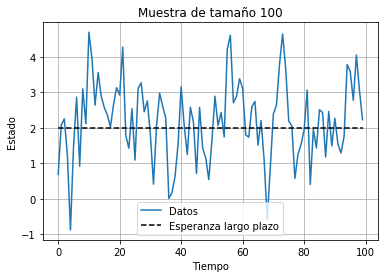

Promedio:  2.196562892975885
Esperanza al largo plazo:  2.0


In [20]:
# Parámetros
np.random.seed(6)
c = 1
phi = 0.5
sigmaSqr = 1
mean = c / (1 - phi)
std = sigmaSqr / (1 - phi**2)

# Generación de datos.
def genDatos(n = 100):
    # Genera una muestra del modelo AR(1) de tamaño n.
    eps = np.random.normal(0, sigmaSqr, n)
    Y = np.empty(n)
    Y[0] = c + eps[0]
    for i in range(1, n):
        Y[i] = c + phi * Y[i - 1] + eps[i]
    return Y 

# Visualización de los datos.
n = 100
Y = genDatos(n)
plt.title("Muestra de tamaño "  + str(n))
plt.xlabel('Tiempo')
plt.ylabel('Estado')
plt.plot(Y, label='Datos')
plt.plot(np.ones(n) * mean, '--k', label='Esperanza largo plazo')
plt.legend(loc='lower center')
plt.grid()
plt.show()
print("Promedio: ", np.mean(Y))
print('Esperanza al largo plazo: ', mean)

Maximizamos la versimilitud de los datos $\left\{ y_1,...,y_n\right\}$ que resulta ser:

$$
p(y_1,...,y_n|c, \varphi, \sigma^2) = \frac{1}{(2\pi \sigma^2)^{n/2}}exp(-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i -c-\varphi     y_{i-1})^2)
$$

Dado que queremos maximizar este valor sobre $\theta \in \mathbb{R} \times \mathbb{R} \times \mathbb{R}_{+}$ , conviene usar la log verosimilitud $l(\theta)$:

$$
\begin{align}
    l(c, \varphi, \sigma^2) = -\frac{n}{2}log(2\pi \sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^{n}(y_i - c -\varphi y_{i-1})^2
\end{align}
$$

<ipython-input-112-4489ba684122>:20: RuntimeWarning: divide by zero encountered in log
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2
<ipython-input-112-4489ba684122>:20: RuntimeWarning: divide by zero encountered in double_scalars
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2
<ipython-input-112-4489ba684122>:20: RuntimeWarning: invalid value encountered in double_scalars
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2


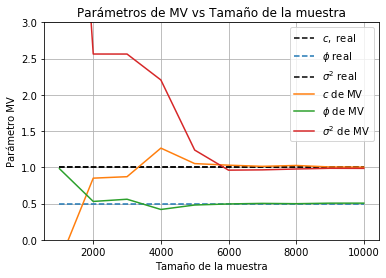

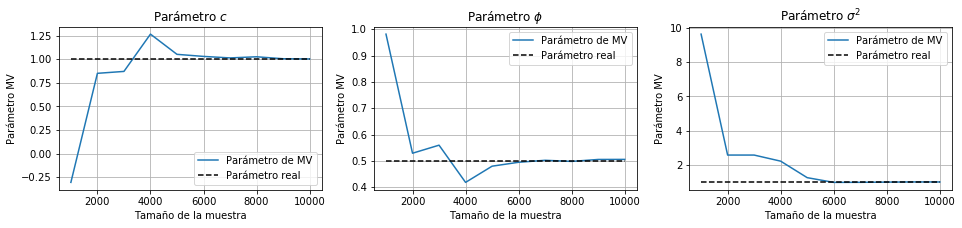

   Tamaño de la muestra         c      \phi  \sigma^2
0                  1000 -0.302952  0.981282  9.651370
1                  2000  0.850595  0.529153  2.563128
2                  3000  0.870701  0.559698  2.562757
3                  4000  1.265086  0.418439  2.205119
4                  5000  1.051355  0.479955  1.238082
5                  6000  1.029484  0.494795  0.960949
6                  7000  1.013611  0.502344  0.964931
7                  8000  1.025559  0.498109  0.976798
8                  9000  1.004743  0.505488  0.986618
9                 10000  1.002672  0.505725  0.985246


In [112]:
# Seteamos la seed.
np.random.seed(6)

def maxVer():
    # Calcula y plotea parámetros de máxima verosimilitud variando la cantidad de muestras.
    
    # Arreglos que guardarán los parámetros.
    arrC = [10]
    arrPhi = [10]
    arrSigmaSqr = [10]
    
    # Generamos muestra de tamaño N = 10000.
    N = 10000
    Y = genDatos(N)
    x = np.arange(1000, N + 1, 1000)
    
    for i in range(len(x)):
        n = x[i]
        #Definimos la función -logVerosimilitud.
        minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 
                                                                                   for i in range(1, n)) 
        #Minimizamos
        bound = ((None, None), (None, None), (0, None))
        opti = minimize(minusLogVer, [arrC[i], arrPhi[i], arrSigmaSqr[i]], method='L-BFGS-B', bounds=bound)
        arrC.append(opti.x[0])
        arrPhi.append(opti.x[1])
        arrSigmaSqr.append(opti.x[2])
    
    # Plot todo junto para informe.
    
    plt.plot(x, c * np.ones(len(x)), '--k', label='$c,$ real')
    plt.plot(x, phi * np.ones(len(x)), '--', label='$\phi$ real')
    plt.plot(x, c * np.ones(len(x)), '--k', label='$\sigma^2$ real')
    plt.plot(x, arrC[1:], label='$c$ de MV')
    plt.plot(x, arrPhi[1:], label='$\phi$ de MV')
    plt.plot(x, arrSigmaSqr[1:], label='$\sigma^2$ de MV')

    plt.title('Parámetros de MV vs Tamaño de la muestra')
    plt.xlabel('Tamaño de la muestra')
    plt.ylabel('Parámetro MV')
    plt.ylim(0, 3)
    plt.grid()
    plt.legend()
    plt.show()

    # Plot por separado.
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 3))

    # c:
    ax[0].plot(x, arrC[1:], label='Parámetro de MV')
    ax[0].plot(x, c * np.ones(len(x)), '--k', label='Parámetro real')
    ax[0].set_title('Parámetro $c$')
    ax[0].set_xlabel('Tamaño de la muestra')
    ax[0].set_ylabel('Parámetro MV')
    ax[0].grid()
    ax[0].legend()
    # phi: 
    ax[1].plot(x, arrPhi[1:], label='Parámetro de MV')
    ax[1].plot(x, phi * np.ones(len(x)), '--k', label='Parámetro real')
    ax[1].set_title('Parámetro $\phi$')
    ax[1].set_xlabel('Tamaño de la muestra')
    ax[1].set_ylabel('Parámetro MV')
    ax[1].grid()
    ax[1].legend()
    # sigma^2:
    ax[2].plot(x, arrSigmaSqr[1:], label='Parámetro de MV')
    ax[2].plot(x, sigmaSqr * np.ones(len(x)), '--k', label='Parámetro real')
    ax[2].set_title('Parámetro $\sigma^2$')
    ax[2].set_xlabel('Tamaño de la muestra')
    ax[2].set_ylabel('Parámetro MV')
    ax[2].grid()
    ax[2].legend()
    plt.show()
    
    # Guardamos en un DataFrame.
    df = pd.DataFrame()
    df['Tamaño de la muestra'] = x
    df['c'] = arrC[1:]
    df['phi'] = arrPhi[1:]
    df['sigma^2'] = arrSigmaSqr[1:]
    print(df)
    
    
    
maxVer()

# Parte (e)
Proponemos un prior uniforme en $A := [c_1,c_2] \times (\varphi_1, \varphi_2) \times [\sigma^2_1, \sigma^2_1]$, es decir:

$$
p(c, \varphi, \sigma^2) = \frac{1}{(c_2 - c_1)(\varphi_2 - \varphi_1)(\sigma^2_2 - \sigma^2_1)}\mathbb{1}_{A}
$$

Luego la densidad a posteriori será proporcional a la verosimilitud:

$$
\begin{align*}
    p(c, \varphi, \sigma^2|\vec{y}_n) &\propto \frac{p(\vec{y}_n|c, \varphi, \sigma^2)}{(c_2 - c_1)(\varphi_2 - \varphi_1)(\sigma^2_2 - \sigma^2_1)}\\
    &\propto p(\vec{y}_n|c, \varphi, \sigma^2)
\end{align*}
$$
Esto no agrega nueva información para maximizar, puesto que sólo son constantes. Es decir, el MAP para una a priori uniforme será el mismo que el MV. 

In [113]:
# Prior uniforme:
c1 = -3
c2 = 3
phi1 = -1
phi2 = 1
sigmaSqr1 = 1 / 2
sigmaSqr2 = 2

def MAP1():    
    # Arreglos que guardarán los parámetros.
    arrC = [10]
    arrPhi = [10]
    arrSigmaSqr = [10]
    
    # Generamos muestra de tamaño N = 10000.
    N = 10000
    Y = genDatos(N)
    x = np.arange(1000, N + 1, 1000)
    
    for i in range(len(x)):
        n = x[i]
        #Definimos la función -log(p(theta|D)).
        minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2 
                                        for i in range(1, n)) -np.log((c2 - c1) * (phi2 - phi1) * (sigmaSqr2 - sigmaSqr1)) 
        #Minimizamos
        bound = ((None, None), (None, None), (0, None))
        opti = minimize(minusLogVer, [arrC[i], arrPhi[i], arrSigmaSqr[i]], method='L-BFGS-B', bounds=bound)
        arrC.append(opti.x[0])
        arrPhi.append(opti.x[1])
        arrSigmaSqr.append(opti.x[2])
        
    # Guardamos en un DataFrame.
    df = pd.DataFrame()
    df['Tamaño de la muestra'] = x
    df['c'] = arrC[1:]
    df['\phi'] = arrPhi[1:]
    df['\sigma^2'] = arrSigmaSqr[1:]
    print(df)
    
MAP1()

<ipython-input-113-0e43899556c4>:41: RuntimeWarning: divide by zero encountered in log
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2
<ipython-input-113-0e43899556c4>:41: RuntimeWarning: divide by zero encountered in double_scalars
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2
<ipython-input-113-0e43899556c4>:41: RuntimeWarning: invalid value encountered in double_scalars
  minusLogVer = lambda theta: (n / 2) * np.log(2 * np.pi * theta[2]) + (1 / (2 * theta[2])) * sum((Y[i] - theta[0] - theta[1]*Y[i - 1])**2


   Tamaño de la muestra         c      \phi  \sigma^2
0                  1000 -0.214267  0.943488  9.734882
1                  2000  2.774960 -0.328251  5.681937
2                  3000  0.609225  0.652402  3.586966
3                  4000  1.532605  0.283729  2.192090
4                  5000  1.119032  0.422092  1.943547
5                  6000  1.016708  0.479581  0.995015
6                  7000  0.998219  0.487214  0.986212
7                  8000  0.988150  0.494568  0.980759
8                  9000  0.985362  0.497938  0.983979
9                 10000  0.999494  0.493299  0.987543


# Parte (f)
Asumiremos que tenemos un valor más probable dentro de cada intervalo. Esta nueva información se traducirá en que nuestras nuevas prior serán densidades $Beta$ desplazadas al intervalo correspondiente y parámetros $\alpha$ y $\beta$ de forma que la esperanza de la nueva variable sea justamente el valor al cual se cree más cercano el parámetro.

In [13]:
# Tomamos los valores reales para comparar.
cProb = (c1 + c2) / 2
amp0 = (cProb - c1) / (c2 - cProb)
phiProb = phi
amp1 = (phiProb - phi1) / (phi2 - phiProb)
sigmaSqrProv = sigmaSqr
amp2 = (sigmaSqrProv - sigmaSqr1) / (sigmaSqr2 - sigmaSqrProv)
beta = 1

def betaDesplazada(x, alpha, beta, a, b):
    # Retorna densidad de Z = a + (b - a)*X evaluada en x donde X es Beta(alpha, beta)
    delta = b - a
    x = (x - a) / delta
    return stats.beta.pdf(x, alpha, beta) * (1 / delta)

def logPrior2(theta):
    # Retorna valor proporcional -log(p(theta)). Con prior Beta desplazada.
    c = theta[0]
    amp0 = cProb
    phi = theta[1]
    sigmaSqr = theta[2]
    if c1 <= c <= c2 and phi1 < phi < phi2 and sigmaSqr1 <= sigmaSqr <= sigmaSqr2:
        dens = betaDesplazada(c, beta *  amp0, beta, c1, c2) * betaDesplazada(phi, beta *  amp1, beta, phi1, phi2) * betaDesplazada(sigmaSqr, beta *  amp2, beta, sigmaSqr1, sigmaSqr2)
        return -np.log(dens)
    else:
        return 0
    
# Negative log likelihood.
def NLL2(theta):
    # Negative log likelihood.
    c = theta[0]
    phi = theta[1]
    sigmaSqr = theta[2]
    return minusLogVer(theta) - logPrior2(theta)

# Optimizamos.
bound = ((c1, c2), (phi1, phi2), (sigmaSqr1, sigmaSqr2))
opti = minimize(NLL2, [1.4, 1.5, 1.8], method='SLSQP', bounds=bound)
df = pd.DataFrame()
df['Nombres'] = ['C', 'phi', 'sigmaSqr']
df['Parám. Reales'] = [c, phi, sigmaSqr] 
df['MAP'] = [opti.x[0], opti.x[1], opti.x[2]]
print(df)

    Nombres  Parám. Reales  MAP
0         C            1.0  1.4
1       phi            0.5  1.0
2  sigmaSqr            1.0  1.8


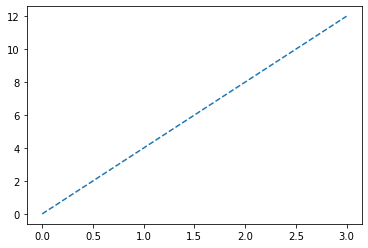

In [99]:
plt.plot(np.arange(4) * 4, '--')
plt.show()